In [1]:
import numpy as np
import torch
import os
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 20)
plt.rcParams['image.interpolation'] = 'bilinear'

from argparse import ArgumentParser

from torch.optim import SGD, Adam
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Normalize
from torchvision.transforms import ToTensor, ToPILImage
import torchvision
import torchvision.transforms as T
import torch.nn.functional as F
import torch.nn as nn
from torch.optim import lr_scheduler
from networks.network_SegNet_512 import SegNet

import collections
import numbers
import random
import math
from PIL import Image, ImageOps, ImageEnhance
import logging
import time
import tool
# import bcolz

In [2]:
CROSS_VALIDATION_FOLD = 0 # 0-4
SEED = CROSS_VALIDATION_FOLD * 100

In [3]:
log_filename = 'train1_SegNet_5_512-fold'+str(CROSS_VALIDATION_FOLD)+'.log'

In [4]:
logging.basicConfig(filename=log_filename, level=logging.INFO, 
                   format='%(asctime)s:%(levelname)s:%(message)s')
def log(message):
    print(message)
    logging.info(message)

In [5]:
log('='*50 + 'start run' + '='*50)

==================================================start run==================================================


## dataset

In [6]:
NUM_CHANNELS = 3
NUM_CLASSES = 2 # car is 1, background is 0

# color_transform = Colorize(n=NUM_CLASSES)
# image_transform = ToPILImage()

In [16]:
random_rotate = tool.Random_Rotate_Crop(maxAngle = 10)
crop = tool.Random_Rotate_Crop(maxAngle = 0)
crop_512 = tool.RandomCrop(crop_size = 512)
random_color = tool.RandomColor()
to_tensor_label = tool.ToTensor_Label()
normalize = tool.ImageNormalize([.485, .456, .406], [.229, .224, .225])
train_transforms = tool.Compose([random_rotate, crop_512, random_color, to_tensor_label, normalize])
val_transforms = tool.Compose([crop, crop_512, to_tensor_label, normalize])

In [17]:
image_path = '../data/images_flip/train/'
mask_path = '../data/images_flip/train_masks/'

In [18]:
with open('../data/train_shuffle_names.pk', 'rb') as f:
    filenames = pickle.load(f)

In [19]:
fold_num = len(filenames) // 5
folds = []
for i in range(5):
    if i == 4:
        folds.append(filenames[i * fold_num :])
    else:
        folds.append(filenames[i * fold_num : (i + 1) * fold_num])

train_filenames = []
for i in range(5):
    if i == CROSS_VALIDATION_FOLD:
        val_filenames = folds[i]
    else:
        train_filenames += folds[i]

In [20]:
# train_filenames = train_filenames[:10]
# val_filenames = val_filenames[:10]

In [21]:
train_set = tool.Car_dataset(image_path, mask_path, train_filenames, train_transforms) 
val_set = tool.Car_dataset(image_path, mask_path, val_filenames, val_transforms) # for validation set

In [22]:
train_loader = DataLoader(train_set, num_workers=4, batch_size=4, shuffle=True)
val_loader = DataLoader(val_set, num_workers=4, batch_size=1) # for validation set

## dataset examples

In [23]:
train_loader.batch_size

4

In [24]:
inp, tar = val_loader.__iter__().next()

In [25]:
i = 0
inp = Variable(inp)
tar = Variable(tar)
# tar[:, 0]
t = tar[i].cpu().data.numpy()
inpu = inp[i].cpu().data.numpy()

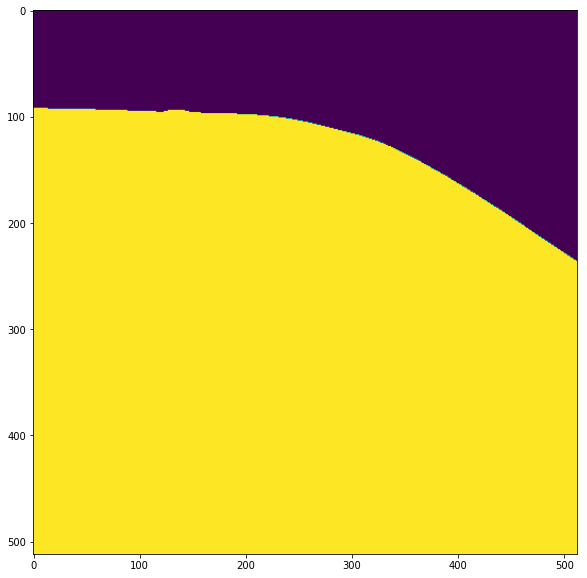

In [26]:
plt.rcParams['figure.figsize'] = (10, 10)
plt.imshow(t[0])
# plt.imshow(inpu[0])

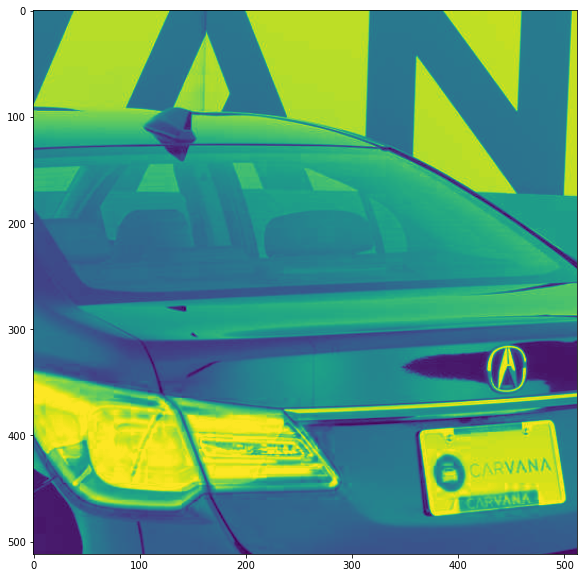

In [27]:
plt.imshow(inpu[0])

## model

In [28]:
torch.cuda.manual_seed_all(SEED)

In [29]:
model = SegNet(NUM_CLASSES)
model = model.cuda()
# load the weights for the trained model
# model.load_state_dict(torch.load('models/SegNet_5-512-0.00561.pth'))

## train define

In [30]:
class CrossEntropyLoss2d(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(CrossEntropyLoss2d, self).__init__()
        self.loss = nn.NLLLoss(weight, size_average)

    def forward(self, outputs, targets):
        return self.loss(F.log_softmax(outputs, dim=1), targets)

In [31]:
def train(epoch, steps_plot=0):
    model.train()

    weight = torch.ones(NUM_CLASSES)
#     weight[1] = 5 # weight of wall is 5

    criterion = CrossEntropyLoss2d(weight.cuda()) # loss function

    epoch_loss = []
    step_loss = []

    for step, (images, labels) in enumerate(train_loader):
        
        images = images.cuda()
        labels = labels.cuda()

        inputs = Variable(images)
        targets = Variable(labels)
        outputs = model(inputs)

        optimizer.zero_grad()
        loss = criterion(outputs, targets[:, 0])
        loss.backward()
        optimizer.step()

        epoch_loss.append(loss.item())
        step_loss.append(loss.item())
        
        if step % 10 == 0:
            average_step_loss = sum(step_loss) / len(step_loss)
            message = 'Epoch[{}]({}/{}): \tloss: {:.4}'.format(epoch, step, len(train_loader), average_step_loss)
            log(message)
            step_loss = []
    average = sum(epoch_loss) / len(epoch_loss)
    message = 'Train: Epoch[{}] \taverage loss: {:.4}'.format(epoch, average)
    log(message)

In [32]:
def test(steps_plot = 0):
    model.eval()

    weight = torch.ones(NUM_CLASSES)
#     weight[1] = 5 # weight of wall is 5

    criterion = CrossEntropyLoss2d(weight.cuda())

#     for epoch in range(start_epoch, end_epochs+1):
    total_loss = []

    for step, (images, labels) in enumerate(val_loader):

        images = images.cuda()
        labels = labels.cuda()

        inputs = Variable(images)
        targets = Variable(labels)
        outputs = model(inputs)

        loss = criterion(outputs, targets[:, 0])

        total_loss.append(loss.item())

    average = sum(total_loss) / len(total_loss)
    message = 'Validation: \taverage loss: {:.4}'.format(average)
    log(message)
    return average

## train


In [33]:
model_name = 'SegNet_5_512'
save_weights_path = '../_weights/'

In [34]:
optimizer = Adam(model.parameters(), lr = 1e-3)
scheduler = lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.5)
val_losses = []
start_time = time.time()
epoch_num = 250
for epoch in range(epoch_num):
    scheduler.step()
    message = 'learning rate: ' + str(scheduler.get_lr()[0])
    log(message)
    train(epoch)
    log('-'*100)
    
    if epoch == 0:
        t1 = time.time()
        message = 'one epoch time: ' + str(t1 - start_time) + 's'
        log(message)
        log('-'*100)
        
    val_loss = test()
    log('-'*100)
    
    val_losses.append(val_loss)
    if val_loss == min(val_losses) and epoch >= 100:
        save_file_name = save_weights_path+model_name+'-fold'+str(CROSS_VALIDATION_FOLD)+'-%.5f' % val_loss+'.pth'
        torch.save(model.state_dict(), save_file_name)
    
end_time = time.time()
total_time = end_time - start_time
average_time = total_time / epoch_num
message = 'total_time: ' + str(total_time) + 's' + '\t\taverage_time: ' + str(average_time) + 's'
log(message)

learning rate: 0.001
Epoch[0](0/1018): loss: 0.6485
Epoch[0](10/1018): loss: 0.538
Epoch[0](20/1018): loss: 0.4866
Epoch[0](30/1018): loss: 0.3657
Epoch[0](40/1018): loss: 0.3927
Epoch[0](50/1018): loss: 0.3842
Epoch[0](60/1018): loss: 0.3729
Epoch[0](70/1018): loss: 0.3978
Epoch[0](80/1018): loss: 0.2882
Epoch[0](90/1018): loss: 0.3293


Process Process-8:
Process Process-5:
Process Process-7:
Process Process-6:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/yini/.virtualenv/my_python3_env/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = index_queue.get()
  File "/u

KeyboardInterrupt: 

In [ ]:
save_file_name = save_weights_path+model_name+'-fold'+str(CROSS_VALIDATION_FOLD)+'-%.5f' % val_loss+'.pth'

In [ ]:
save_file_name